[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/Yquetzal/tnetwork/blob/master/article_benchmark_reproduction.ipynb)

# Reproducing results of the benchmark article
This notebook allow the reproduce restults of the article:
`Evaluating Community Detection Algorithms for Progressively Evolving Graphs`

In [1]:
#If you have not installed tnetwork yet, you need to install it first, for instance with this line

#!pip install --upgrade git+https://github.com/Yquetzal/tnetwork.git

In [2]:
%load_ext autoreload
%autoreload 2
import tnetwork as tn
import numpy as np
import seaborn as sns
import pandas as pd
import seaborn as sns
from tnetwork.experiments.experiments import *
import matplotlib.pyplot as plt
import datetime
from tnetwork import ComScenario

We start by defined the list of methods to test. In order to be able to execute the code online, we removed DYNAMO and transveral_network approaches that require to run locally (use of JAVA/Matlab)

In [3]:
elapsed_time=True
def iterative(x, elapsed_time=elapsed_time):
    return tn.DCD.iterative_match(x, elapsed_time=elapsed_time)
def smoothed_louvain(x, elapsed_time=True):
    return tn.DCD.smoothed_louvain(x, elapsed_time=elapsed_time)
def smoothed_graph(x, elapsed_time=True):
    return tn.DCD.smoothed_graph(x, elapsed_time=elapsed_time, alpha=0.9)
#def label_smoothing(x, elapsed_time=True):
#    return tn.DCD.label_smoothing(x, elapsed_time=elapsed_time)

#def DYNAMO(x, elapsed_time=True):
#    return tn.DCD.externals.dynamo(x, elapsed_time=elapsed_time,timeout=100)
#def transversal_network(x, elapsed_time=True):
#    return tn.DCD.externals.transversal_network_mucha_original(x, elapsed_time=elapsed_time,om=0.5, matlab_session=eng)

methods_to_test = { "smoothed-graph":smoothed_graph,
                   "implicit-global": smoothed_louvain,
                   "no-smoothing":iterative,
                   #"label-smoothing":label_smoothing
                  }

## Qualitative analysis
We define the custom scenario on which to make experiments, following the paper. 

### Definition of the custom scenario
The function is part of `tnetwork` library, but we reproduce it here as a code example

In [4]:
def generate_toy_random_network(**kwargs):
    """
    Generate a small, toy dynamic graph

    Generate a toy dynamic graph with evolving communities, following scenario described in XXX
    Optional parameters are the same as those passed to the ComScenario class to generate custom scenarios

    :return: pair, (dynamic graph, dynamic reference partition) (as snapshots)
    """
    my_scenario = ComScenario(**kwargs)

    # Initialization with 4 communities of different sizes
    [A, B, C, T] = my_scenario.INITIALIZE([5, 8, 20, 8],
                                                                ["A", "B", "C", "T"])
    # Create a theseus ship after 20 steps
    (T,U)=my_scenario.THESEUS(T, delay=20)

    # Merge two of the original communities after 30 steps
    B = my_scenario.MERGE([A, B], B.label(), delay=30)

    # Split a community of size 20 in 2 communities of size 15 and 5
    (C, C1) = my_scenario.SPLIT(C, ["C", "C1"], [15, 5], delay=75)

    # Split again the largest one, 40 steps after the end of the first split
    (C1, C2) = my_scenario.SPLIT(C, ["C", "C2"], [10, 5], delay=40)

    # Merge the smallest community created by the split, and the one created by the first merge
    my_scenario.MERGE([C2, B], B.label(), delay=20)

    # Make a new community appear with 5 nodes, disappear and reappear twice, grow by 5 nodes and disappear
    R = my_scenario.BIRTH(5, t=25, label="R")
    R = my_scenario.RESURGENCE(R, delay=10)
    R = my_scenario.RESURGENCE(R, delay=10)
    R = my_scenario.RESURGENCE(R, delay=10)

    # Make the resurgent community grow by 5 nodes 4 timesteps after being ready
    R = my_scenario.GROW_ITERATIVE(R, 5, delay=4)

    # Kill the community grown above, 10 steps after the end of the addition of the last node
    my_scenario.DEATH(R, delay=10)

    (dyn_graph, dyn_com) = my_scenario.run()
    dyn_graph_sn = dyn_graph.to_DynGraphSN(slices=1)
    GT_as_sn = dyn_com.to_DynCommunitiesSN(slices=1)
    return dyn_graph_sn, GT_as_sn

### Generation of the two flavors, Sharp and Blurred

In [5]:
dyn_graph_sharp,dyn_com_sharp= tn.generate_toy_random_network(random_noise=0.01, external_density_penalty=0.05,alpha=0.9)
dyn_graph_blurred,dyn_com_blurred= tn.generate_toy_random_network(random_noise=0.01, external_density_penalty=0.25,alpha=0.8)

100% (26 of 26) |########################| Elapsed Time: 0:00:00 ETA:  00:00:00

### Plotting the ground truth

/usr/local/lib/python3.7/site-packages/numpy/core/numeric.py:2327: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


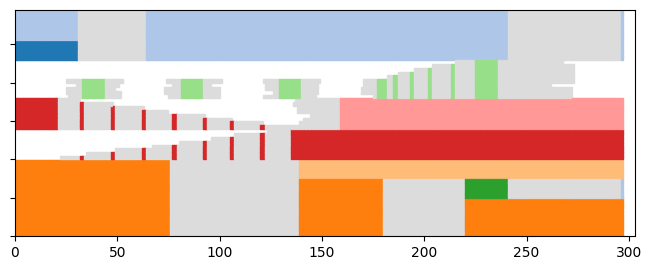

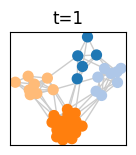

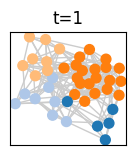

In [6]:
node_order = dyn_com_sharp.automatic_node_order()
p = tn.plot_longitudinal(dyn_graph_sharp,dyn_com_sharp,nodes=node_order,height=300)
plt.show(p)
p = tn.plot_as_graph(dyn_graph_sharp,dyn_com_sharp,ts=1, height=150,width=150)
plt.show(p)
p = tn.plot_as_graph(dyn_graph_blurred,dyn_com_blurred,ts=1, height=150,width=150)


### Run all algorithms
We use a function of tnetwork which takes a graph and a list of methods and return the communities.
We then plot the results. We do it only for the sharp scenario in this example

In [7]:
coms_sharp = tn.run_algos_on_graph(methods_to_test,dyn_graph_sharp)

N/A% (0 of 297) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

starting smoothed_graph


N/A% (0 of 297) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

starting smoothed_louvain


N/A% (0 of 297) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

starting no_smoothing


 96% (286 of 297) |##################### | Elapsed Time: 0:00:01 ETA:   0:00:00

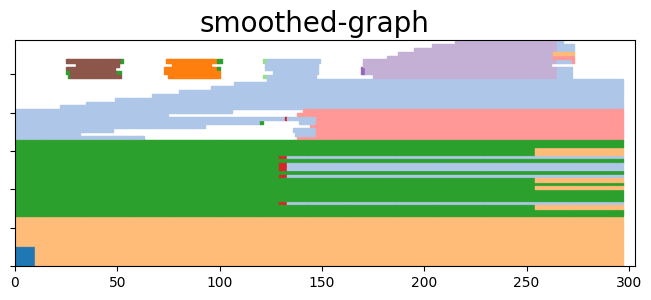

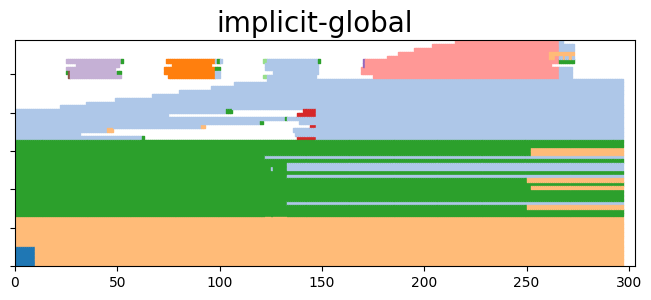

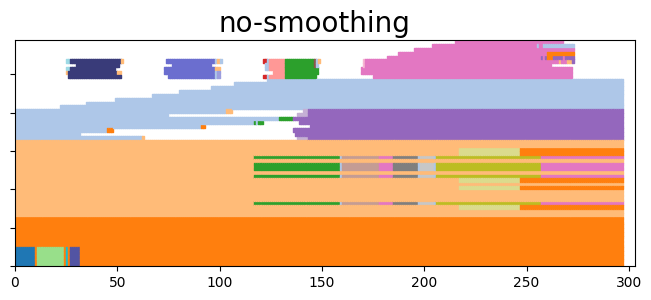

In [8]:
for name,(communities,time) in coms_sharp.items():
    to_plot = tn.plot_longitudinal(communities=communities,height=300)
    to_plot.suptitle(name, fontsize=20)
    plt.show(to_plot)

## Quantitative analysis

### Computing community qualities
The first test consists in computing scores when varying mu and keeping all other parameters constant. 
In order to run it quickly online, we choose only 3 values of mu and run only 1 iteration for each.

We use a function of `tnetwork` which, given a set of parameters, generate networks according to the generator described in the paper and compute all scores for them

**Be careful**, it takes a few minutes

In [9]:
#mus = [0,0.05]+[0.1,0.15,0.2]+[0.3,0.4,0.5]
mus = [0,0.15,0.3]
df_stats = tn.DCD_benchmark(methods_to_test,mus,iterations=1)


mu:  0
iteration:  0
generating graph with nb_com =  10


N/A% (0 of 1565) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

subset length: None
starting smoothed_graph


N/A% (0 of 1565) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

starting smoothed_louvain


N/A% (0 of 1565) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

starting no_smoothing


 99% (1563 of 1565) |################### | Elapsed Time: 0:00:24 ETA:   0:00:00

mu:  0.15
iteration:  0
generating graph with nb_com =  10


N/A% (0 of 821) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

subset length: None
starting smoothed_graph


N/A% (0 of 821) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

starting smoothed_louvain


N/A% (0 of 821) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

starting no_smoothing


 99% (816 of 821) |##################### | Elapsed Time: 0:00:10 ETA:   0:00:00

mu:  0.3
iteration:  0
generating graph with nb_com =  10


N/A% (0 of 776) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

subset length: None
starting smoothed_graph


N/A% (0 of 776) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

starting smoothed_louvain


N/A% (0 of 776) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

starting no_smoothing


 99% (773 of 776) |##################### | Elapsed Time: 0:00:15 ETA:   0:00:00

Compute stats


### Visualize results
First with the longitudinal plots

<Figure size 1080x360 with 0 Axes>

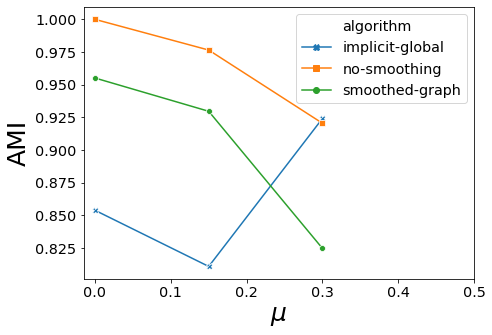

<Figure size 288x216 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

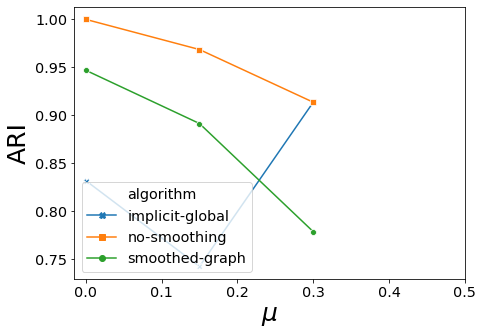

<Figure size 288x216 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

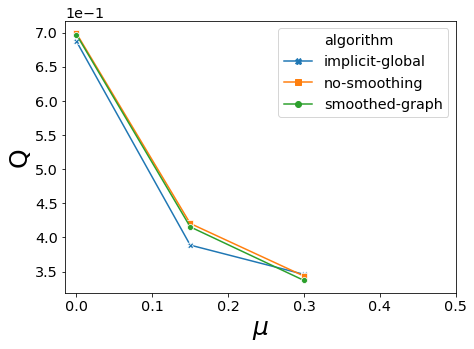

<Figure size 288x216 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

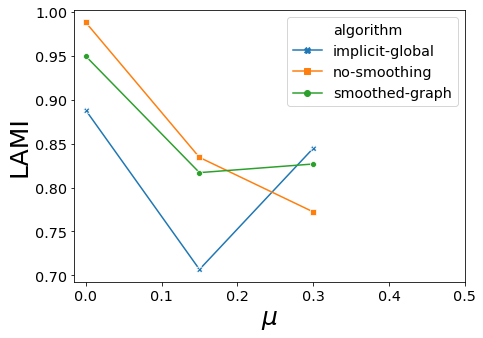

<Figure size 288x216 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

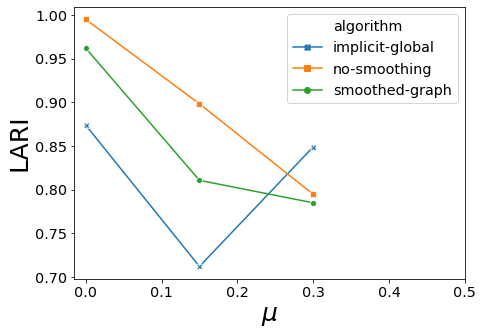

<Figure size 288x216 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

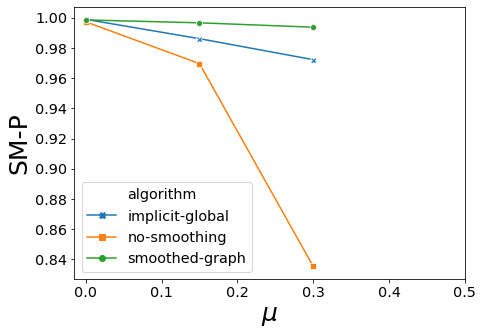

<Figure size 288x216 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

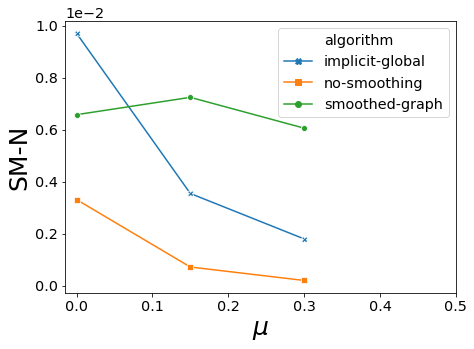

<Figure size 288x216 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

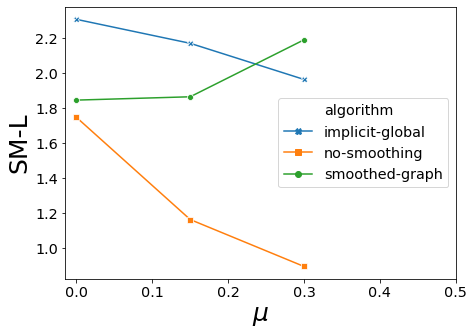

<Figure size 288x216 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

for carac in ["AMI","ARI","Q","LAMI","LARI","SM-P","SM-N","SM-L"]:
    plt.clf()
    
    sorted_methods_names = sorted(list(set(df_stats["algorithm"])))


    fig, ax = plt.subplots(figsize=(7, 5))
    ax = sns.lineplot(x="mu", y=carac, ax=ax,hue="algorithm",hue_order=sorted_methods_names,style="algorithm",legend="full",data=df_stats,dashes=False,markers=True,err_kws={"alpha":0.05})#,err_style="bars")
    ax.set_xlabel("$\mu$", fontsize=25)
    ax.set_ylabel(carac, fontsize=25)
    ax.set_xticks(np.arange(0.0, 0.51, 0.1))
    ax.ticklabel_format(axis="y",scilimits=(-1,1),style="sci")


    handles,labels = ax.get_legend_handles_labels()
    figlegend = pylab.figure(figsize=(4,3))
    figlegend.legend(handles,labels,loc="center")
    #ax.get_legend().remove()
    plt.show(fig)
#plt.show(figlegend)





### Then visualize using a spider web plot

In [11]:
df_stats = df_stats.drop([0])

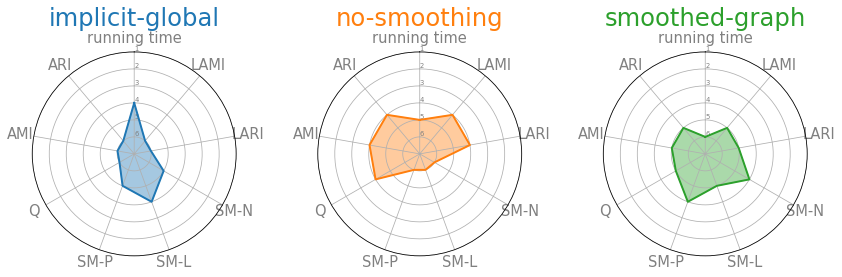

In [12]:
df = df_stats[df_stats["mu"]==0.15].groupby('algorithm', as_index=False).mean()
df['LAMI'] = df['LAMI'].rank(ascending=True)
df['LARI'] = df['LARI'].rank(ascending=True)
df['SM-N'] = df['SM-N'].rank(ascending=True)
df['SM-L'] = df['SM-L'].rank(ascending=True)
df['SM-P'] = df['SM-P'].rank(ascending=True)
df['Q'] = df['Q'].rank(ascending=True)
df['AMI'] = df['AMI'].rank(ascending=True)
df['ARI'] = df['ARI'].rank(ascending=True)
df['running time'] = df['running time'].rank(ascending=False)


df = df.drop(columns=[ "mu", "iteration", "# nodes","# steps", "#coms"])

# ------- PART 1: Define a function that do a plot for one line of the dataset!

pi=3.14159
def make_spider( row, title, color):

    # number of variable
    categories=list(df)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(2,3,row+1, polar=True, )

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=15)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([1,2,3,4,5,6], ["6","5","4","3","2","1"], color="grey", size=7)
    plt.ylim(0,6)

    # Ind1
    values=df.loc[row].drop('algorithm').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=25, color=color, y=1.1)

    # ------- PART 2: Apply to all individuals
    # initialize the figure
my_dpi=70
plt.figure(figsize=(1000/my_dpi, 700/my_dpi), dpi=my_dpi)

# Create a color palette:
#my_palette = plt.cm.get_cmap("Set2", len(df.index))
my_pallete = sns.color_palette()
# Loop to plot
for row in range(0, len(df.index)):
    make_spider( row=row, title=df['algorithm'][row], color=my_pallete[row])

plt.subplots_adjust(wspace=0.4)

## Evaluate scalability
### First by varying the number of steps
Again, we do it only for a few values for the sake of example

In [13]:
#steps= [100,200,400,800,1200,1600,2000]
steps= [100,200,400]

df_stats = tn.DCD_benchmark(methods_to_test,mus=[0.2],nb_coms=[10],subsets=steps,iterations=1,operations=40)

mu:  0.2
iteration:  0
generating graph with nb_com =  10


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

subset length: 100
starting smoothed_graph


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

starting smoothed_louvain


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

starting no_smoothing


N/A% (0 of 200) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

subset length: 200
starting smoothed_graph


N/A% (0 of 200) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

starting smoothed_louvain


N/A% (0 of 200) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

starting no_smoothing


N/A% (0 of 400) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

subset length: 400
starting smoothed_graph


N/A% (0 of 400) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

starting smoothed_louvain


N/A% (0 of 400) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

starting no_smoothing


 98% (395 of 400) |##################### | Elapsed Time: 0:00:06 ETA:   0:00:00

Compute stats


<Figure size 1080x360 with 0 Axes>

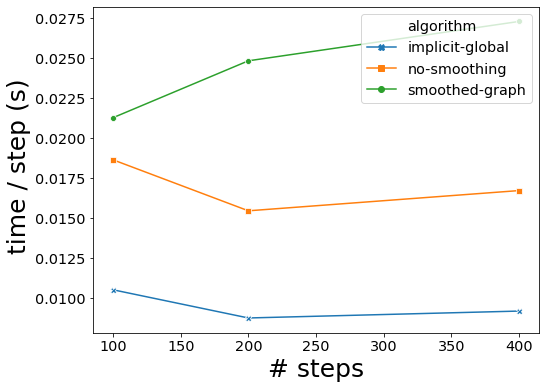

In [14]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

df_stats["running time"] = df_stats["running time"]/df_stats["# steps"]
df_stats = df_stats[df_stats["# steps"]>50]

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

for carac in ["running time"]:
    plt.clf()
    
    fig, ax = plt.subplots(figsize=(8, 6))
    sorted_methods_names = sorted(list(set(df_stats["algorithm"])))
    ax = sns.lineplot(x="# steps", y=carac, ax=ax,hue="algorithm",hue_order=sorted_methods_names,style="algorithm",legend="full",data=df_stats,dashes=False,markers=True,err_kws={"alpha":0.05})#,err_style="bars")
    ax.set_xlabel("# steps", fontsize=25)
    ax.set_ylabel(" time / step (s)", fontsize=25)



### Secondly by varying the number of nodes

In [15]:
#nb_coms = [10,25,50,75,100]
nb_coms = [10,15,20]

df_stats = tn.DCD_benchmark(methods_to_test, mus=[0.2],nb_coms=nb_coms,subsets=[50],iterations=1,operations=5)

mu:  0.2
iteration:  0
generating graph with nb_com =  10


N/A% (0 of 50) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

subset length: 50
starting smoothed_graph


N/A% (0 of 50) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

starting smoothed_louvain


N/A% (0 of 50) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

starting no_smoothing


 96% (48 of 50) |####################### | Elapsed Time: 0:00:00 ETA:   0:00:00

generating graph with nb_com =  15


N/A% (0 of 50) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

subset length: 50
starting smoothed_graph


N/A% (0 of 50) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

starting smoothed_louvain


N/A% (0 of 50) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

starting no_smoothing


 94% (47 of 50) |######################  | Elapsed Time: 0:00:01 ETA:   0:00:00

generating graph with nb_com =  20


N/A% (0 of 50) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

subset length: 50
starting smoothed_graph


N/A% (0 of 50) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

starting smoothed_louvain


N/A% (0 of 50) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

starting no_smoothing


 98% (49 of 50) |####################### | Elapsed Time: 0:00:01 ETA:   0:00:00

Compute stats


<Figure size 1080x360 with 0 Axes>

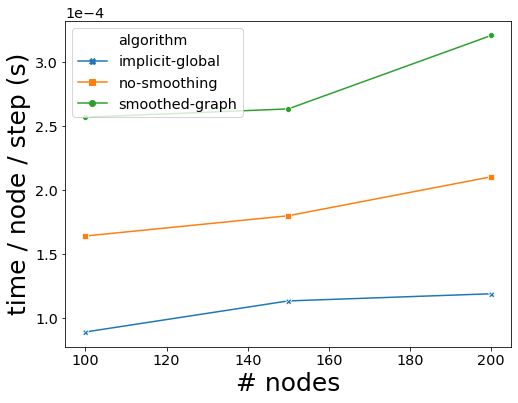

In [16]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

df_stats["#coms"] = df_stats["#coms"]*10
df_stats["running time"] = df_stats["running time"]/(df_stats["# nodes"])/df_stats["# steps"]



#df_stats["#coms"] = df_stats["#coms"]*10
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

for carac in ["running time"]:
    plt.clf()
    
    fig, ax = plt.subplots(figsize=(8, 6))
    sorted_methods_names = sorted(list(set(df_stats["algorithm"])))


    ax = sns.lineplot(x="#coms", y=carac, ax=ax,hue="algorithm",style="algorithm",hue_order=sorted_methods_names,legend="full",data=df_stats,dashes=False,markers=True,err_kws={"alpha":0.05})#,err_style="bars")
    ax.set_xlabel("# nodes", fontsize=25)
    ax.set_ylabel("time / node / step (s)", fontsize=25)
    ax.ticklabel_format(axis="y",scilimits=(-1,1),style="sci")




